In [1]:
#import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import json

In [2]:
#Read logins json, converting dates to datetime index
df = pd.read_json("logins.json",convert_dates=True)

# Part 1 ‑ Exploratory data analysis

In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
df = df.set_index(df['login_time']).sort_index()

In [6]:
df['number_of_logins'] = 1

In [7]:
df = df.resample('15T').count()

In [8]:
df = df.drop(['login_time'],axis=1)

In [9]:
#Extract day of the week
df['weekday'] = df.index.dayofweek

#Extract month
df['month'] = df.index.month

#Extract hour
df['hour'] = df.index.hour

In [10]:
df.head()

,number_of_logins,weekday,month,hour
login_time,,,,
1970-01-01 20:00:00,2,3,1,20
1970-01-01 20:15:00,6,3,1,20
1970-01-01 20:30:00,9,3,1,20
1970-01-01 20:45:00,7,3,1,20
1970-01-01 21:00:00,1,3,1,21


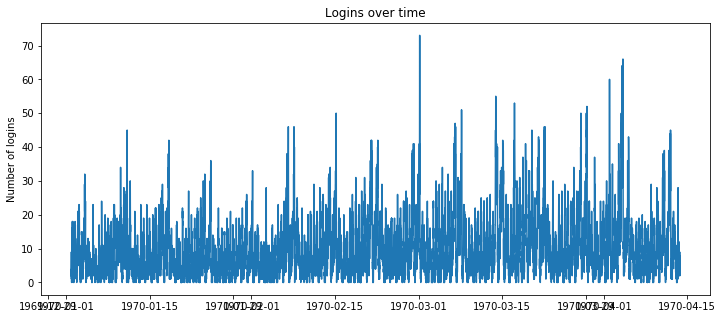

In [11]:
plt.figure(figsize=(12,5))
_ = plt.plot(df['number_of_logins'])
_ = plt.ylabel('Number of logins')
_ = plt.title('Logins over time')

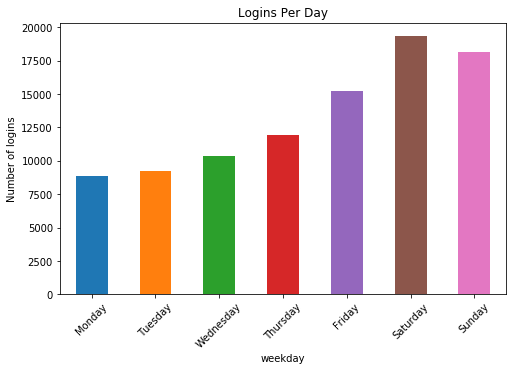

In [12]:
plt.figure(figsize=(8,5))
_ = df.groupby('weekday')['number_of_logins'].sum().plot(kind='bar')
_ = plt.xticks([0,1,2,3,4,5,6], 
           ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
_ = plt.ylabel('Number of logins')
_ = plt.title('Logins Per Day')

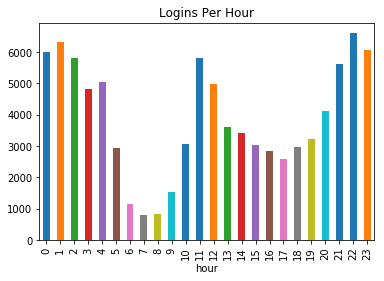

In [13]:
_ = df.groupby('hour')['number_of_logins'].sum().plot(kind='bar')
_ = plt.title('Logins Per Hour')

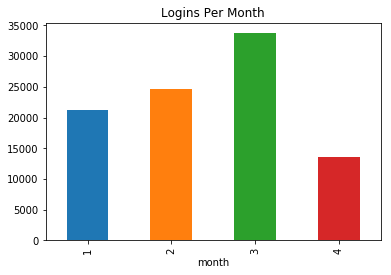

In [14]:
_ = df.groupby('month')['number_of_logins'].sum().plot(kind='bar')
_ = plt.title('Logins Per Month')

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would choose the percentage increase in activity (i.e. number of rides) per driver as the key measure of success, especially during the slow times per city. This would allow us to determine if reimbursing toll costs results in an overall increase in the number of rides per driver, which would ultimately mean an increase in Ultimate's revenue.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the observation
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

I would implement A/B testing with 2 sets of drivers: a test group and a control group. The test group would have all toll costs reimbursed while the control group would still have to pay their tolls. The null hypothesis is that there is no change in the number of rides between the test group and the control group. The alternative hypothesis is that the test group has more rides than the control group. I would test the statistical significane of the results using a 2-sample t-test with a 95% confidence interval (p-value of 0.05). If the null hypothesis is rejected and the alternative hypothesis, I would recommend the tolls be reimbursed. Otherwise, I would recommend against it.

# Part 3 ‑ Predictive modeling

In [15]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

In [16]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [18]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [19]:
df.last_trip_date.sort_values(ascending=False)[0]

Timestamp('2014-06-17 00:00:00')

In [20]:
import datetime
s = '2014-06-17'
d = datetime.datetime.strptime(s, '%Y-%m-%d') - datetime.timedelta(days=30)
print(d.strftime('%m/%d/%Y'))

05/18/2014


In [21]:
df['active_or_not'] = (df.last_trip_date > '2014-05-17').astype(int)

In [22]:
df.drop(['last_trip_date'],axis=1,inplace=True)

In [23]:
df["avg_rating_by_driver"] = df["avg_rating_by_driver"].fillna(round(df.avg_rating_by_driver.mean(),1))
df["avg_rating_of_driver"] = df["avg_rating_of_driver"].fillna(round(df.avg_rating_by_driver.mean(),1))

In [24]:
df.dropna(inplace=True)

In [25]:
city_encoded = pd.get_dummies(df.city.apply(pd.Series).stack(),drop_first=True).sum(level=0)
df = df.join(city_encoded)

In [26]:
phone_encoded = pd.get_dummies(df.phone.apply(pd.Series).stack(),drop_first=True).sum(level=0)
df = df.join(phone_encoded)

In [27]:
df = df.drop(columns = ['city','phone'])

In [28]:
date = df[['signup_date']]
date = date.set_index('signup_date')

In [29]:
df['signup_day'] = date.index.dayofweek

In [30]:
df = df.drop(['signup_date'],axis=1)

In [31]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype('int')

In [32]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df=df.rename(columns = {'''king's_landing''':'kings_landing'})

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null int32
weekday_pct               49604 non-null float64
active_or_not             49604 non-null int32
kings_landing             49604 non-null uint8
winterfell                49604 non-null uint8
iphone                    49604 non-null uint8
signup_day                49604 non-null int64
dtypes: float64(6), int32(2), int64(2), uint8(3)
memory usage: 3.9 MB


In [34]:
cat_columns = ['active_or_not','kings_landing','winterfell','iphone','ultimate_black_user','signup_day']
for i in cat_columns:
    df[i] = df[i].astype('category')

In [35]:
df.reset_index(inplace=True,drop=True)

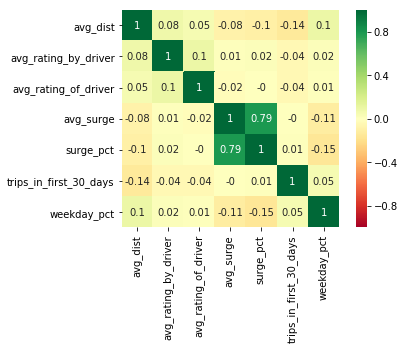

In [36]:
_ = sns.heatmap(df.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Multicollinearity analysis
#Get features
feature_x = df.drop(['active_or_not'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
1,68.780275,avg_rating_by_driver
2,52.552474,avg_rating_of_driver
3,50.351993,avg_surge
11,4.284209,signup_day
7,4.015099,weekday_pct


In [38]:
df = df.drop(columns=['avg_rating_by_driver'])

In [39]:
feature_x = df.drop(['active_or_not'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
2,39.182262,avg_surge
1,33.460988,avg_rating_of_driver
10,4.213482,signup_day
6,3.956638,weekday_pct
9,3.279152,iphone


In [40]:
df = df.drop(columns=['avg_surge'])

In [41]:
feature_x = df.drop(['active_or_not'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
1,12.284643,avg_rating_of_driver
9,4.100819,signup_day
5,3.862062,weekday_pct
8,3.230511,iphone
7,2.343005,winterfell


45.5 % of observed users were retained


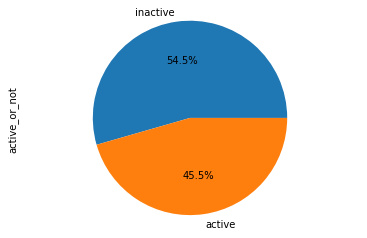

In [42]:
print(format(df.active_or_not.astype('int').sum()/df.active_or_not.astype('int').count()*100,'1.1f'), '% of observed users were retained')
_ = df.active_or_not.value_counts().plot(kind='pie',labels=['inactive','active'],autopct='%1.1f%%')
_ = plt.axis('equal')

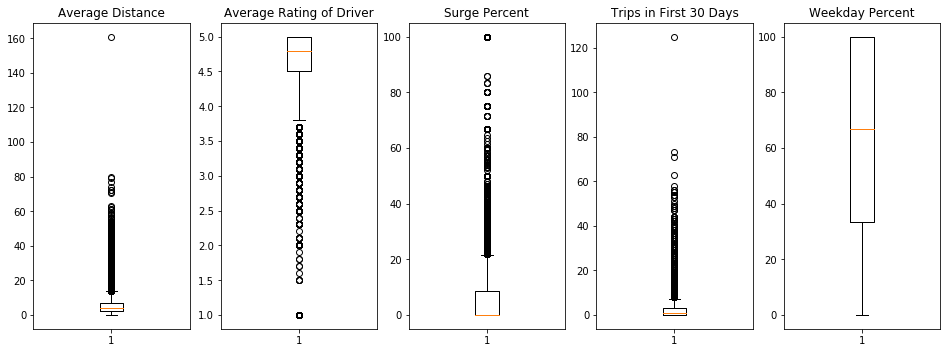

In [43]:
cleaned = df
fig, axs = plt.subplots(1,5,figsize=(14,5))
_ = axs[0].boxplot(cleaned.avg_dist)
axs[0].set_title('Average Distance')
_ = axs[1].boxplot(cleaned.avg_rating_of_driver)
axs[1].set_title('Average Rating of Driver')
_ = axs[2].boxplot(cleaned.surge_pct)
axs[2].set_title('Surge Percent')
_ = axs[3].boxplot(cleaned.trips_in_first_30_days)
axs[3].set_title('Trips in First 30 Days')
_ = axs[4].boxplot(cleaned.weekday_pct)
axs[4].set_title('Weekday Percent')
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=1.5, wspace=0.2)

In [44]:
from sklearn.preprocessing import MinMaxScaler

#Initialize scaler
scaler = MinMaxScaler() 
  
# Scaled features
df_transformed = scaler.fit_transform(df[['avg_dist', 'avg_rating_of_driver', 'surge_pct',
                                               'trips_in_first_30_days','weekday_pct']])

#Convert scaled features to dataframe
scaled_df = pd.DataFrame(df_transformed,columns=['avg_dist', 'avg_rating_of_driver', 'surge_pct',
                                               'trips_in_first_30_days','weekday_pct'])
scaled_df.describe()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,avg_dist,avg_rating_of_driver,surge_pct,trips_in_first_30_days,weekday_pct
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,0.035943,0.908398,0.088753,0.018218,0.608838
std,0.035224,0.142484,0.199890,0.030346,0.370862
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015035,0.875000,0.000000,0.000000,0.333000
50%,0.024105,0.950000,0.000000,0.008000,0.667000
75%,0.043054,1.000000,0.087000,0.024000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
cat_frame = df.drop(['avg_dist', 'avg_rating_of_driver', 'surge_pct',
                                               'trips_in_first_30_days','weekday_pct'],axis=1)
df_scaled = scaled_df.join(cat_frame)

In [46]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 11 columns):
avg_dist                  49604 non-null float64
avg_rating_of_driver      49604 non-null float64
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null float64
weekday_pct               49604 non-null float64
ultimate_black_user       49604 non-null category
active_or_not             49604 non-null category
kings_landing             49604 non-null category
winterfell                49604 non-null category
iphone                    49604 non-null category
signup_day                49604 non-null category
dtypes: category(6), float64(5)
memory usage: 2.2 MB


## Machine Learning

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
y = df_scaled['active_or_not'].tolist()
X = df_scaled.drop(['active_or_not'],axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(solver='liblinear',max_iter = 500, random_state=42)

#Cross-validate on training set
cv_accuracy_lr = cross_val_score(lr, X_train, y_train,cv=5,scoring='accuracy')

# train model
lr.fit(X_train, y_train)

# predict on test data
y_pred_lr = lr.predict(X_test)

In [67]:
print("Train Accuracy:",format(np.mean(cv_accuracy_lr),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_lr),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_lr),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_lr))

Train Accuracy: 0.67179
Test Accuracy: 0.66752
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6266         1831
Actual 1         3117         3668
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      8097
           1       0.67      0.54      0.60      6785

   micro avg       0.67      0.67      0.67     14882
   macro avg       0.67      0.66      0.66     14882
weighted avg       0.67      0.67      0.66     14882



### Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='accuracy')

# train model
rf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test)

In [65]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.72922
Test Accuracy: 0.72181
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6021         2076
Actual 1         2064         4721
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8097
           1       0.69      0.70      0.70      6785

   micro avg       0.72      0.72      0.72     14882
   macro avg       0.72      0.72      0.72     14882
weighted avg       0.72      0.72      0.72     14882



In [68]:
sm_y = np.asarray(y).astype(float)
sm_X = np.asarray(X).astype(float)
sm_X = sm.add_constant(sm_X)
model = sm.OLS(sm_y,sm_X).fit()

#Get influence data
influence = model.get_influence()

#c is the cook's distance and p is p-value
(c, p) = influence.cooks_distance

In [69]:
c_df = pd.DataFrame(c)
print(c_df.sort_values(0,ascending=False).head())
print(c_df.sort_values(0,ascending=False).tail())

              0
18370  0.037532
20542  0.027325
99     0.008043
39965  0.004179
36181  0.003905
                  0
6091   4.896771e-10
40256  1.717066e-10
38679  1.403729e-10
25778  9.102562e-11
43386  2.677988e-11


Text(0.5, 1.0, "Cook's D")

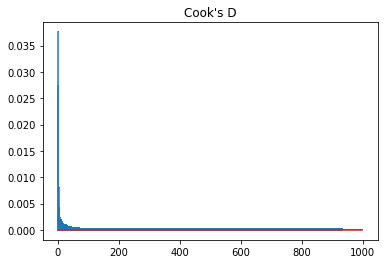

In [72]:
plt.stem(np.arange(1000), c_df.sort_values(0,ascending=False).head(1000), markerfmt=",")
plt.title('Cook\'s D')

In [76]:
#Drop outliers
df_nooutliers = df_scaled.drop([18370,20542])

#Drop target variable from X
X = df_nooutliers.drop(['active_or_not'],axis=1)
y = df_nooutliers['active_or_not'].tolist()

#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [80]:
# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='accuracy')

# train model
rf.fit(X_train, y_train)

#predict on test data
y_pred_rf = rf.predict(X_test)

In [81]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.72875
Test Accuracy: 0.72744
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6072         2059
Actual 1         1997         4753
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      8131
           1       0.70      0.70      0.70      6750

   micro avg       0.73      0.73      0.73     14881
   macro avg       0.73      0.73      0.73     14881
weighted avg       0.73      0.73      0.73     14881



#### Final model

In [82]:
X = df_scaled.drop(['active_or_not'],axis=1)
y = df_scaled['active_or_not'].tolist()

#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [83]:
%%time

# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training set
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='accuracy')

# train model
rf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test)

Wall time: 13.2 s


In [84]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.72922
Test Accuracy: 0.72181
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6021         2076
Actual 1         2064         4721
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8097
           1       0.69      0.70      0.70      6785

   micro avg       0.72      0.72      0.72     14882
   macro avg       0.72      0.72      0.72     14882
weighted avg       0.72      0.72      0.72     14882



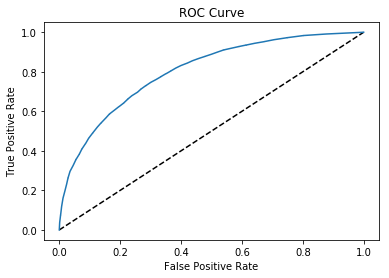

In [85]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

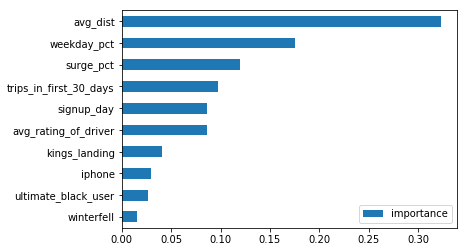

In [86]:
feature_importances_rf = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances_rf.plot(kind='barh')

It looks like the average distance is the most important feature in predicting rider retention. Active users tend to take shorter, but more frequent trips while inactive users tend to take longer but less frequent trips, especially in the first 30 days. This can be seen by looking at the mean average distance for active vs. inactive drivers and looking at the number of trips taken in the first 30 days for active vs. inactive drivers (see below).

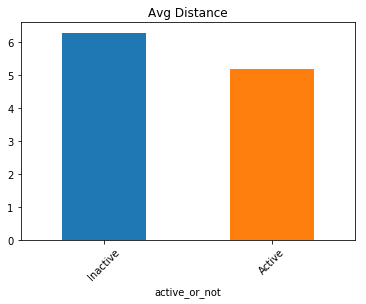

In [87]:
_ = df.groupby('active_or_not')['avg_dist'].mean().plot(kind='bar')
_ = plt.title('Avg Distance')
_ = plt.xticks([0,1],['Inactive','Active'],rotation=45)

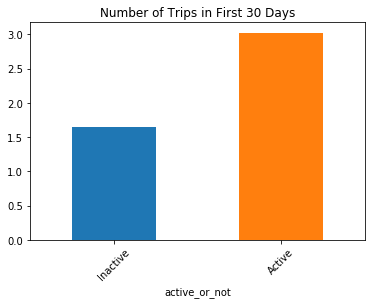

In [88]:
df.groupby('active_or_not')['trips_in_first_30_days'].mean().plot(kind='bar')
_ = plt.title('Number of Trips in First 30 Days')
_ = plt.xticks([0,1],['Inactive','Active'],rotation=45)